#### Dataset :  
URL Source : https://www.kaggle.com/snap/amazon-fine-food-reviews
- This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012.
- Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
- Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite
- database.sqlite: Contains the table 'Reviews'

- Data includes:

   - Reviews from Oct 1999 - Oct 2012
   - 568,454 reviews
   - 256,059 users
   - 74,258 products
   - 260 users with > 50 reviews
   - wordcloud

- Variable Information:
    - Id
    - ProductId - Unique product identifier 
    - UserId - Unqiue User identifier
    - ProfileName - Profile Names
    - HelpfulnessNumerator - Number of users who found the review helpful.
    - HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not.
    - Score - Rating between 1 and 5.
    - Time - Timestamp for the review.
    - Summary - Review summary.
    - Text - Text of the review.

### Objective :
To determine whether a review is positive or negative and build a machine learning model around it .

In [1]:
import re
import sklearn
import numpy as np
import nltk
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import string
from tqdm import tqdm

In [2]:
con = sqlite3.connect("/home/shri/Music/archive/database.sqlite")

In [3]:
data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3 LIMIT 2000""",con)

In [4]:
data = data[["Id","ProductId","UserId","ProfileName","Score","Time","Summary","Text"]]

In [5]:
data.head(5)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
data.Score.value_counts()

5    1413
4     280
1     196
2     111
Name: Score, dtype: int64

Encoding Dataset - Score can be categories into two parts based on Score range form 0 to 5 except 3 as it will be show bies data and it will lead to false results
    - positive review : 4, 5
    - negative review : 1, 2
- Dataset score has for unique values such as 1, 2,4, 5 and for getting objective we need to categories into two values such as 0 and 1 for negative and positive values. 

In [7]:
data.Score

0       5
1       1
2       4
3       2
4       5
       ..
1995    5
1996    4
1997    4
1998    2
1999    5
Name: Score, Length: 2000, dtype: int64

In [8]:
Scores = data.Score
NewScore = Scores.map(lambda x : 0 if x<3 else 1)
data.Score = NewScore
data.head(5)

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
## extracting the number of examples of each class
data_1=len(data.groupby(['Score']).groups[1])
print("Total number of Positive values : ",data_1)
data_0=len(data.groupby(['Score']).groups[0])
print("Total number of Negatite values : ",data_0)

Total number of Positive values :  1693
Total number of Negatite values :  307


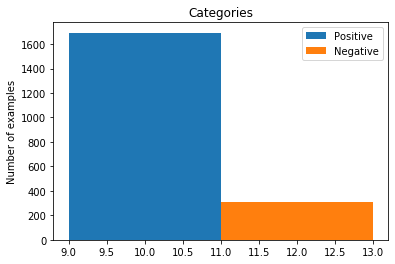

In [10]:
# bar plot of the 3 classes
plt.bar(10,data_1,2, label="Positive")
plt.bar(12,data_0,2, label="Negative")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Categories')
plt.show()

---------------------------------------------------------------------------------------------------------------
- Dataset ma have some duplicates, as we have unique values for productId and UserId so with help of those we can find duplicated data and remove those terms. 
- Dataset shows bised towords positive side, we can balace this dataset using sample select.
---------------------------------------------------------------------------------------------------------------

In [11]:
print(data.duplicated(["ProductId", "UserId"]).sum())

20


In [12]:
sorted_data = data.sort_values("ProductId", axis = 0, ascending=True, inplace = False)
sorted_data.shape

(2000, 8)

In [13]:
duplicated_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Score","Time","Summary","Text"})
duplicated_data.shape

(1998, 8)

In [14]:
print("Final dataset is {} percent of Orginal dataset ".format((duplicated_data.Id.size*1.0)/(data.Id.size*1.0)*100))

Final dataset is 99.9 percent of Orginal dataset 


---------------------------------------------------------------------------------------------------------------
- Only 0.1 percent dataset is duplicated in this dataset.
- With remove duplicates we can use original dataset for modeling.
---------------------------------------------------------------------------------------------------------------

In [15]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
duplicated_data['Length'] = duplicated_data['Text'].apply(length)
duplicated_data.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text,Length
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,475
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,1,961718400,Great Product,This was a really good idea and the final prod...,168
1071,1161,B000084E1U,A3DH85EYHW4AQH,Eric Hochman,1,1140739200,Cats love it!,I have nine cats and they are crazy about thes...,156
1331,1438,B0000VLH8S,APZ1KMTD4SNB9,C. Dembosky,1,1219968000,gold dust is awesome,This product allows me to make some really big...,229
1330,1437,B0000VLH8S,A3OX1UNG90U0G0,S. Woodcock,1,1229472000,shining star,i purchased this item for a cake that called f...,228


In [16]:
Negative = duplicated_data[duplicated_data['Score'] == 0]
Positive = duplicated_data[duplicated_data['Score'] == 1]

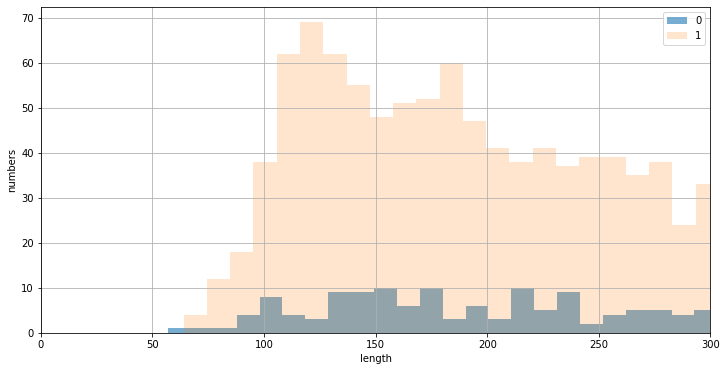

In [17]:
import matplotlib 
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 500
plt.hist(Negative['Length'], alpha = 0.6, bins=bins, label= "0")
plt.hist(Positive['Length'], alpha = 0.2, bins=bins, label= "1")
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.grid()
plt.show()

In [18]:
import nltk
from nltk.tokenize import word_tokenize
reviews = data.Text.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10]

11667


['.', ',', 'the', 'I', 'and', 'a', 'to', 'of', 'it', 'is']

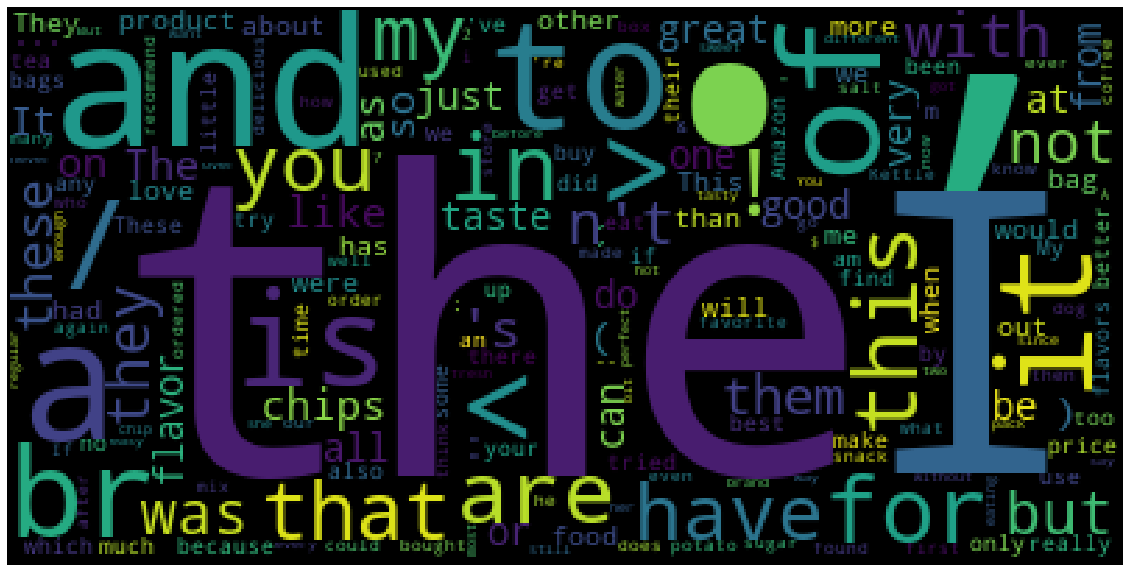

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Cleaning Dataset

#### Remove
    - http
    - special tags
    - Punctutions
    - stopwords
    - single words
    - shortcut's
#### Cleaning 
    - Stemming
    - lower case 

In [20]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm


# https://gist.github.com/kkaran0908/64f8fd91113a0e75ee77715964b41309
# https://datascience.stackexchange.com/questions/53448/nltks-stopwords-returns-typeerror-argument-of-type-lazycorpusloader-is-not
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

clean_text= []
for sentance in tqdm(duplicated_data['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords.words('english'))
    clean_text.append(sentance.strip())

100%|██████████| 1998/1998 [00:21<00:00, 91.73it/s] 


In [21]:
clean_text

['received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'nine cats crazy kibbles last thing want cat food cats hate buying',
 'product allows make really big splashes providing spiced nuts gatherings fact gold spreads easily allows use little show people amazed edible gold',
 'purchased item cake called gold dust never thought would find im glad sprinkled looked like shining star container small go long way worth buying',
 'used product multiple times fact purchased four tubs gold silver luster dust five years ago running use stuff gild sorts things renaissance themed banquets including gilding entire roast duck using vodka painting filigree designs o

In [22]:
data_clean = pd.DataFrame(clean_text,columns =['Texts'])

In [23]:
import nltk
from nltk.tokenize import word_tokenize
reviews = data_clean.Texts.str.cat(sep=' ')
#function to split text into word
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))
frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:10]

7991


['chips',
 'like',
 'good',
 'great',
 'taste',
 'flavor',
 'one',
 'love',
 'would',
 'product']

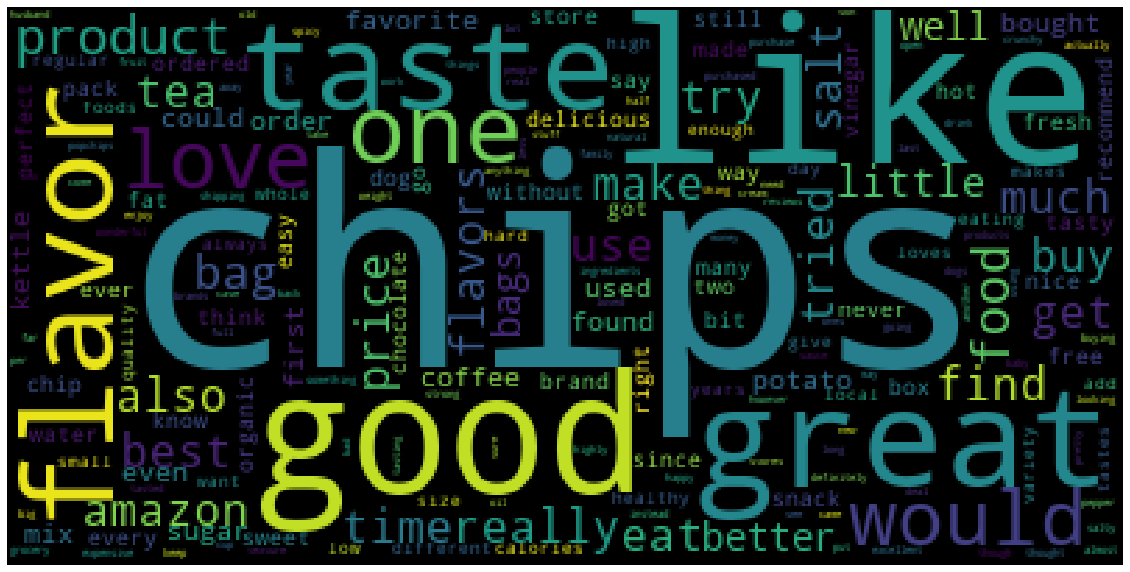

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## BOW

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

In [26]:
counting_var = CountVectorizer()
counting_var = counting_var.fit_transform(np.array(clean_text))
print("-"*110)
print(counting_var[5])
print("-"*110)
print("Unique words: {}".format(counting_var.get_shape()[1]))

--------------------------------------------------------------------------------------------------------------
  (0, 2343)	1
  (0, 5637)	1
  (0, 586)	1
  (0, 5420)	1
  (0, 1293)	1
  (0, 4765)	1
  (0, 1901)	1
  (0, 2638)	1
  (0, 4921)	1
  (0, 7649)	1
  (0, 7542)	1
  (0, 2184)	1
  (0, 5886)	1
  (0, 2355)	1
  (0, 2947)	1
  (0, 3489)	1
  (0, 524)	1
  (0, 7121)	1
  (0, 5736)	1
  (0, 7147)	1
  (0, 6493)	1
  (0, 2946)	1
  (0, 6787)	2
  (0, 5953)	1
  (0, 150)	1
  (0, 7916)	1
  (0, 2673)	1
  (0, 4118)	1
  (0, 6311)	1
  (0, 7367)	1
  (0, 2792)	1
  (0, 7198)	1
  (0, 4508)	1
  (0, 7537)	1
  (0, 4061)	1
  (0, 7163)	1
  (0, 2198)	1
  (0, 5479)	1
  (0, 3002)	1
  (0, 2515)	1
  (0, 2744)	1
  (0, 7536)	1
  (0, 5387)	1
--------------------------------------------------------------------------------------------------------------
Unique words: 7973


In [27]:
from sklearn.manifold import TSNE
vector_of_words_subset = counting_var[:1500]
print(counting_var.shape)
print(vector_of_words_subset.shape)

(1998, 7973)
(1500, 7973)


In [28]:
t_sne = TSNE(n_components=2,random_state =0,perplexity=50)
dim_reduced_corpus = t_sne.fit_transform(vector_of_words_subset.todense())

In [29]:
dim_reduced_corpus.shape
print(dim_reduced_corpus)

[[0.53650934 2.049831  ]
 [0.33501118 1.5844945 ]
 [2.1531174  2.7574363 ]
 ...
 [2.7349916  1.0020763 ]
 [1.0225078  1.393358  ]
 [2.5812578  1.8842957 ]]


In [30]:
type(dim_reduced_corpus)

numpy.ndarray

In [31]:
data

,Id,ProductId,UserId,ProfileName,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...
1995,2177,B002SW7ZOW,A1RPCL4E65WA4Y,April,1,1284681600,Wu-yi is,The tea tastes great and helped me curb cravin...
1996,2178,B002SW7ZOW,A2CIIHVCG2FXSP,"YLuvAmazon ""YLuvAmazon""",1,1268265600,Fine Quality Tea!,I love this TEA. It has a very smooth taste an...
1997,2179,B002SW7ZOW,A3H15E995IH56,"Susan Fliss ""Soapmaker""",1,1274745600,Found at the dollar store,I found this exact same stuff at the dollar st...
1998,2180,B002SW7ZOW,A19ZAMNNIBACDA,E. Smith,0,1320105600,Not the same tea...,I ordered through source in the past and cance...


In [32]:
label = data['Score'].head(1500)
print(label)

0       1
1       0
2       1
3       0
4       1
       ..
1495    1
1496    1
1497    1
1498    1
1499    1
Name: Score, Length: 1500, dtype: int64


In [33]:
label = np.array(label)
label.shape

(1500,)

In [34]:
label1=label.reshape(1500,1)
print(label1.shape)

(1500, 1)


In [35]:
dim_reduced_corpus_label = np.concatenate((dim_reduced_corpus,label1),axis = 1)
print(dim_reduced_corpus_label)

[[0.53650934 2.04983091 1.        ]
 [0.33501118 1.58449447 0.        ]
 [2.15311742 2.75743628 1.        ]
 ...
 [2.73499155 1.00207627 1.        ]
 [1.02250779 1.39335799 1.        ]
 [2.58125782 1.8842957  1.        ]]


In [36]:
dim_reduced_corpus_label_df = pd.DataFrame(dim_reduced_corpus_label,columns=('Dim1','Dim2','Label'))

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


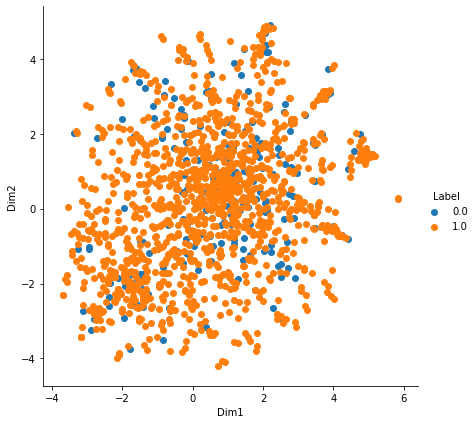

In [38]:
sns.FacetGrid(dim_reduced_corpus_label_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()

plt.show()

## Bi_gram and n-gram

In [39]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
counting_var = CountVectorizer(ngram_range = (1,2), min_df=10, max_features=4000)
bi_gram = counting_var.fit_transform(clean_text)
print("-"*110)
print("Shape of BOW : {}".format(bi_gram.get_shape()))
print("-"*110)
print("Unique words : {}".format(bi_gram.get_shape()[1]))
print("-"*110)

--------------------------------------------------------------------------------------------------------------
Shape of BOW : (1998, 1316)
--------------------------------------------------------------------------------------------------------------
Unique words : 1316
--------------------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


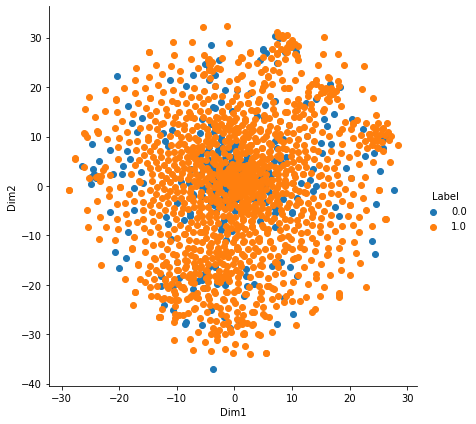

In [41]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
vector_of_words_subset = bi_gram[:1500]
t_sne = TSNE(n_components=2,random_state =0,perplexity=50)
dim_reduced_corpus = t_sne.fit_transform(vector_of_words_subset.todense())
dim_reduced_corpus.shape
label = data['Score'].head(1500)
label = np.array(label)
label1=label.reshape(1500,1)
dim_reduced_corpus_label = np.concatenate((dim_reduced_corpus,label1),axis = 1)
dim_reduced_corpus_label_df = pd.DataFrame(dim_reduced_corpus_label,columns=('Dim1','Dim2','Label'))
sns.FacetGrid(dim_reduced_corpus_label_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()

plt.show()

## TF-IDF 

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
tf_idf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf.fit(clean_text)
print("-"*110)
print(tf_idf.get_feature_names()[0:10])
print("-"*110)

--------------------------------------------------------------------------------------------------------------
['able', 'able find', 'absolute', 'absolutely', 'absolutely love', 'acid', 'across', 'actual', 'actually', 'add']
--------------------------------------------------------------------------------------------------------------


In [44]:

tf_idf = tf_idf.transform(clean_text)
print("-"*110)
print("Shape of BOW : {}".format(tf_idf.get_shape()))
print("-"*110)
print("Unique words : {}".format(tf_idf.get_shape()[1]))
print("-"*110)

--------------------------------------------------------------------------------------------------------------
Shape of BOW : (1998, 1316)
--------------------------------------------------------------------------------------------------------------
Unique words : 1316
--------------------------------------------------------------------------------------------------------------


In [45]:
# store the tf-idf array into pandas dataframe
array = tf_idf.todense()
df = pd.DataFrame(array)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.16056,0.219624,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


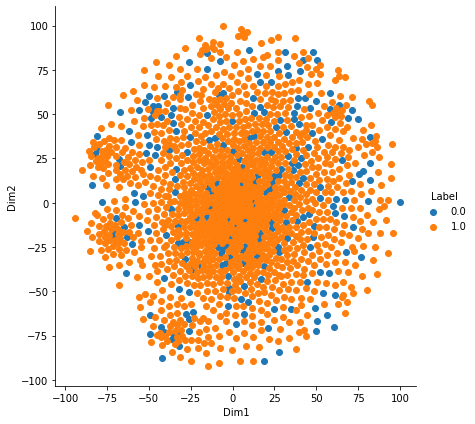

In [46]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
vector_of_words_subset = tf_idf[:1500]
t_sne = TSNE(n_components=2,random_state =0,perplexity=50)
dim_reduced_corpus = t_sne.fit_transform(vector_of_words_subset.todense())
dim_reduced_corpus.shape
label = data['Score'].head(1500)
label = np.array(label)
label1=label.reshape(1500,1)
dim_reduced_corpus_label = np.concatenate((dim_reduced_corpus,label1),axis = 1)
dim_reduced_corpus_label_df = pd.DataFrame(dim_reduced_corpus_label,columns=('Dim1','Dim2','Label'))
sns.FacetGrid(dim_reduced_corpus_label_df, hue = 'Label', size = 6)\
    .map(plt.scatter, 'Dim1', 'Dim2')\
    .add_legend()

plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:71: FutureWarning: Pass input=english as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


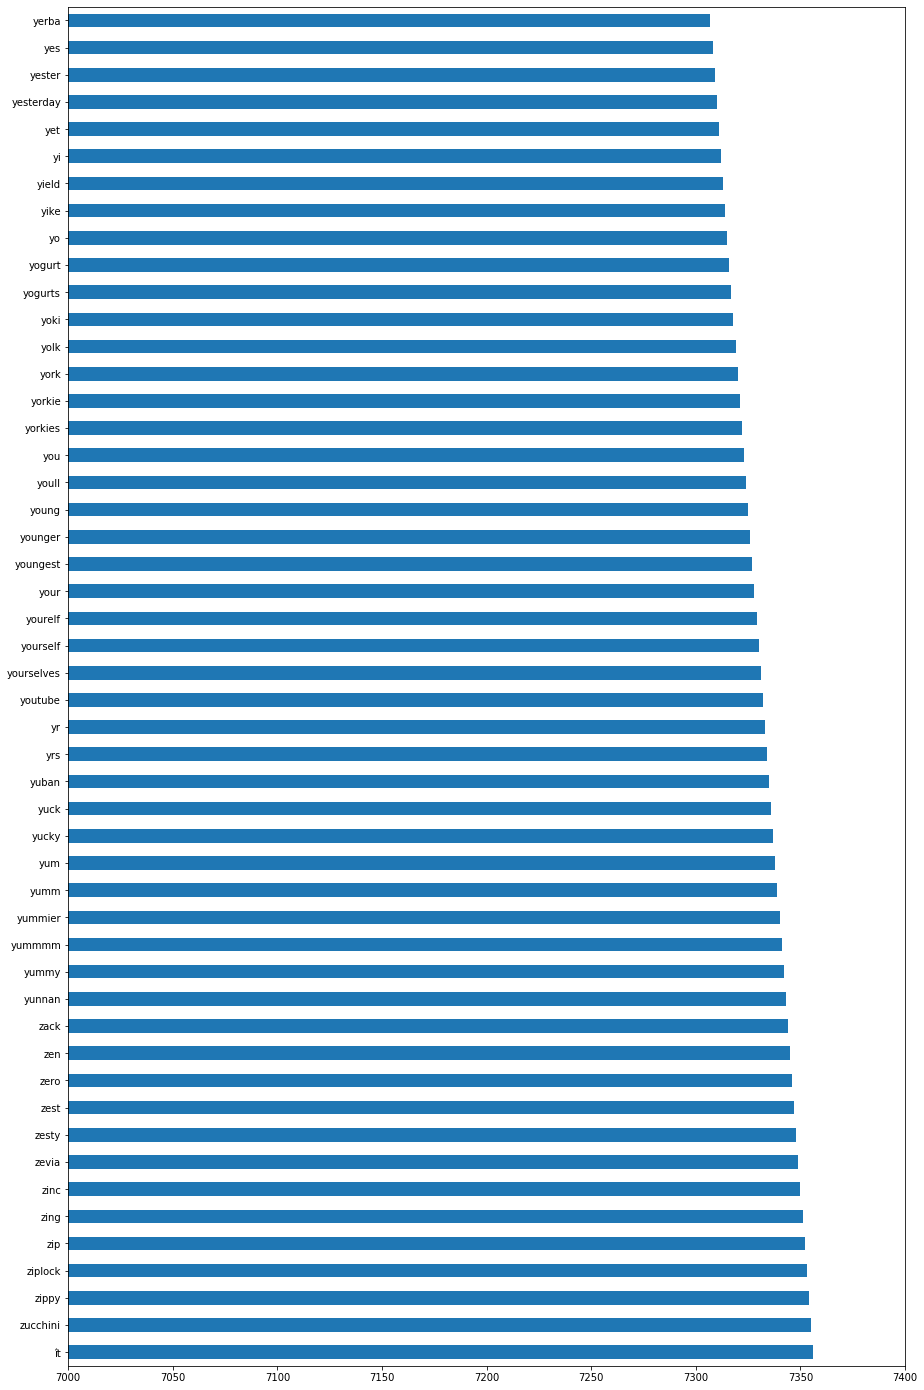

In [47]:
# create the object of tfid vectorizer
EAP_tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
EAP_tfid_vectorizer.fit(Positive['Text'])
# collect the vocabulary items used in the vectorizer
EAP_dictionary = EAP_tfid_vectorizer.vocabulary_.items()
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in EAP_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
EAP_vocab = pd.Series(count, index=vocab)
# sort the dataframe
EAP_vocab = EAP_vocab.sort_values(ascending=False)
# plot of the top vocab
top_vacab = EAP_vocab.head(50)
top_vacab.plot(kind = 'barh', figsize=(15,25), xlim= (7000, 7400))

## Word2Vec

In [48]:
list_of_sen = []
for sen in clean_text:
    list_of_sen.append(sen.split())

In [49]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sen,min_count=5,size=50, workers=4)
    print("-"*110)
    print(w2v_model.wv.most_similar('great'))
    print('-'*115)
    print(w2v_model.wv.most_similar('worst'))
    print('-'*115)
    
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print('-'*115)
        print(w2v_model.wv.most_similar('great'))
        print('-'*115)
        print(w2v_model.wv.most_similar('worst'))
        print('-'*115)
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

--------------------------------------------------------------------------------------------------------------
[('little', 0.9998686909675598), ('still', 0.9998656511306763), ('light', 0.9998471736907959), ('far', 0.9998461604118347), ('lot', 0.9998401403427124), ('pretty', 0.9998385906219482), ('looking', 0.9998384714126587), ('keep', 0.9998376369476318), ('go', 0.9998363852500916), ('good', 0.9998309016227722)]
-------------------------------------------------------------------------------------------------------------------
[('usually', 0.9994555115699768), ('around', 0.9994403123855591), ('company', 0.9994212985038757), ('three', 0.9994211196899414), ('disappointed', 0.9994131326675415), ('work', 0.9993804097175598), ('high', 0.9993792176246643), ('another', 0.9993762373924255), ('enjoyed', 0.9993752241134644), ('look', 0.9993690848350525)]
-------------------------------------------------------------------------------------------------------------------


In [50]:
w2v_words = list(w2v_model.wv.vocab)
print('-'*115)
print("number of words that occured minimum 5 times ",len(w2v_words))
print('-'*115)
print("sample words ", w2v_words[0:50])
print('-'*115)

-------------------------------------------------------------------------------------------------------------------
number of words that occured minimum 5 times  2114
-------------------------------------------------------------------------------------------------------------------
sample words  ['received', 'shipment', 'could', 'hardly', 'wait', 'try', 'product', 'love', 'call', 'instead', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'shop', 'going', 'lot', 'fun', 'everywhere', 'like', 'really', 'good', 'idea', 'outstanding', 'everybody', 'bought', 'made', 'two', 'cats', 'crazy', 'last', 'thing', 'want', 'cat', 'food', 'hate', 'buying', 'allows', 'make', 'big', 'spiced', 'nuts', 'fact', 'gold', 'little', 'show', 'people', 'amazed']
-------------------------------------------------------------------------------------------------------------------


In [51]:
final = pd.DataFrame(data.Score[:1500])

In [52]:
final["text"] = clean_text[:1500]

In [53]:
final = final[["Score","text"]]

In [54]:
final.to_csv('file1.csv') 